# 신림역의 장애인 예상 하차 인원 수(시계열 분석)

In [10]:
import numpy as np
import pandas as pd

In [11]:
df_A = pd.read_csv('../Project3 Data/TSdata_신림A.csv')

In [12]:
df_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ds      1461 non-null   int64
 1   y       1461 non-null   int64
dtypes: int64(2)
memory usage: 23.0 KB


In [13]:
df_A['ds'] = df_A['ds'].astype(str) # 스트링처리 후 날짜타입으로 전환
df_A['ds']=pd.to_datetime(df_A['ds'])

In [14]:
df_A

,ds,y
0,2015-01-01,39099
1,2015-01-02,73386
2,2015-01-03,60706
3,2015-01-04,48524
4,2015-01-05,79606
...,...,...
1456,2018-12-27,76095
1457,2018-12-28,77721
1458,2018-12-29,60020
1459,2018-12-30,46456


## 과거 데이터 확인

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:>

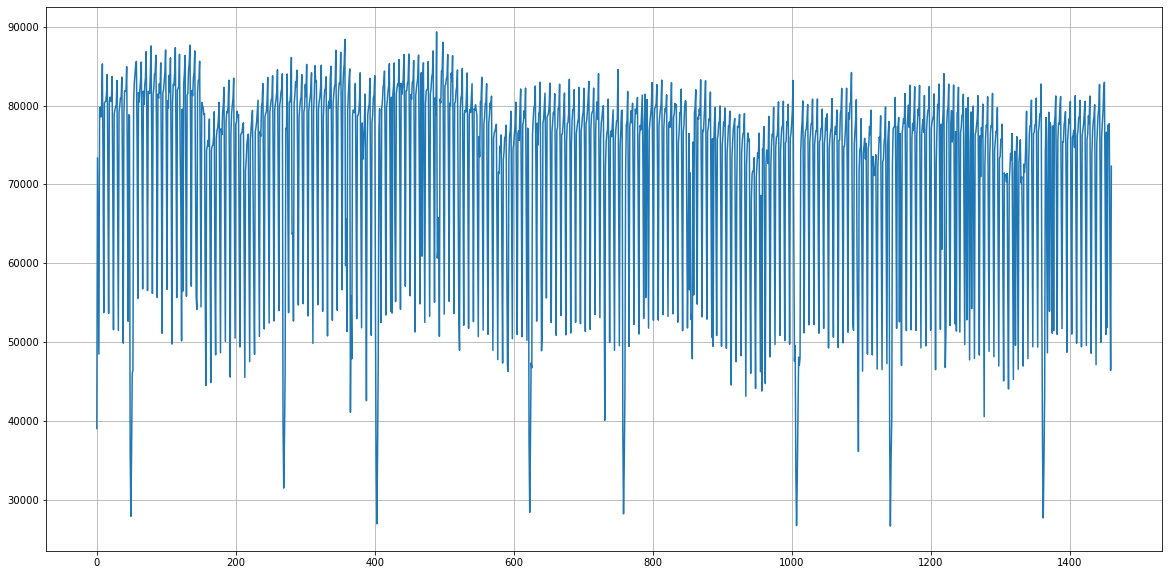

In [16]:
df_A['y'].plot(figsize=(20, 10), grid=True)

## Holiday Effects의 적용

#### 전반적으로 신정(새해), 구정 연휴, 추석 연휴에 장애인의 지하철 이용이 급격히 감소.
#### 하지만 컴퓨터는 각각의 날이 특별한 의미를 갖는지 알 수 없음. -> 단순 이상값으로 판단해버림.
#### 명절에 따른 하차 인원의 감소는 인과관계가 명확하기 때문에,
#### 컴퓨터가 해당 날짜들을 이상값으로 판단하여 무시하게 두는 것은 옳지 않다고 생각함.

In [17]:
nationalHolidays = pd.DataFrame({
    'holiday': 'nationalHolidays',
    'ds': pd.to_datetime(['2015-02-19', '2015-09-27', '2016-02-08', '2016-09-15',
                          '2017-01-18', '2017-10-04', '2018-02-16', '2018-09-24',
                          '2019-02-05', '2019-09-13']),
    'lower_window': -1,
    'upper_window': 1,
}) # lower -1 = 전날까지, upper + 1 = 다음날까지 (연휴 반영)

newYear = pd.DataFrame({
    'holiday': 'newYear',
    'ds': pd.to_datetime(['2015-01-01','2016-01-01','2017-01-01',
                          '2018-01-01','2019-01-01']),
})

holidays = pd.concat((nationalHolidays, newYear))

### 예측 날짜 구간 생성

In [29]:
future = m.make_future_dataframe(periods=365) # 향후 1년간
future.tail()

,ds
1821,2019-12-27
1822,2019-12-28
1823,2019-12-29
1824,2019-12-30
1825,2019-12-31


In [30]:
from fbprophet import Prophet
m = Prophet(holidays=holidays, daily_seasonality=True)

In [31]:
forecast = m.fit(df_A).predict(future)

### 신뢰 구간을 포함한 예측 실행

In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1821,2019-12-27,78636.005991,71890.143980,85212.618052
1822,2019-12-28,64834.774806,57780.753931,72071.157500
1823,2019-12-29,48709.756934,42159.687676,55080.183419
1824,2019-12-30,73203.238785,66845.806775,79990.293558
1825,2019-12-31,74199.667335,67509.175369,80951.092493


## 2019년 예측 결과

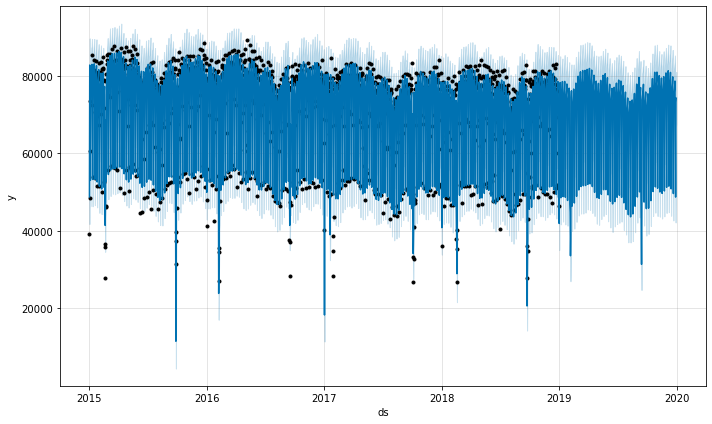

In [33]:
m.plot(forecast);

### 예측 결과에 반영된 Holiday Effects의 보정 수치 확인하기

In [34]:
forecast[(forecast['nationalHolidays'] + forecast['newYear']) != 0][
      ['ds', 'nationalHolidays', 'newYear']][-7:]

,ds,nationalHolidays,newYear
1461,2019-01-01,0.000000,-32240.895596
1495,2019-02-04,-26392.282493,0.000000
1496,2019-02-05,-38583.650323,0.000000
1497,2019-02-06,-34300.937955,0.000000
1715,2019-09-12,-26392.282493,0.000000
1716,2019-09-13,-38583.650323,0.000000
1717,2019-09-14,-34300.937955,0.000000


## 실제 데이터와 예측값의 비교

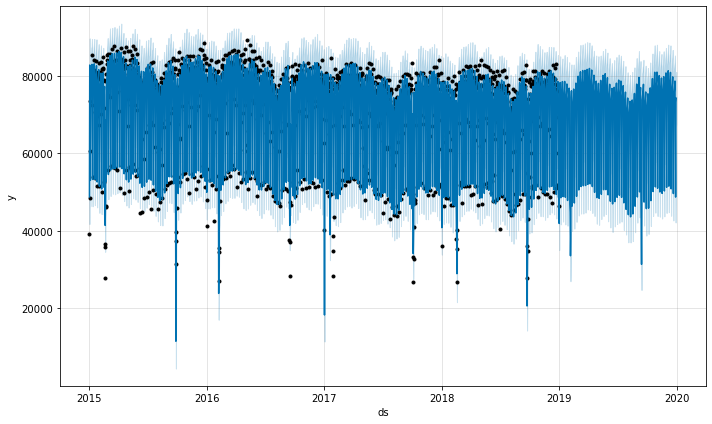

In [35]:
m.plot(forecast);

### 실제 데이터(2019년) 가져오기

In [36]:
df_A2 = pd.read_csv('../project3/TSdata_신림A2.csv')

df_A2['ds'] = df_A2['ds'].astype(str) # 스트링처리 후 날짜타입으로 전환
df_A2['ds']=pd.to_datetime(df_A2['ds'])

df_A2

,ds,y
0,2019-01-01,36283
1,2019-01-02,73692
2,2019-01-03,75650
3,2019-01-04,78947
4,2019-01-05,62877
...,...,...
360,2019-12-27,80167
361,2019-12-28,64970
362,2019-12-29,47771
363,2019-12-30,74193


## 2019년 상반기 예측 비교

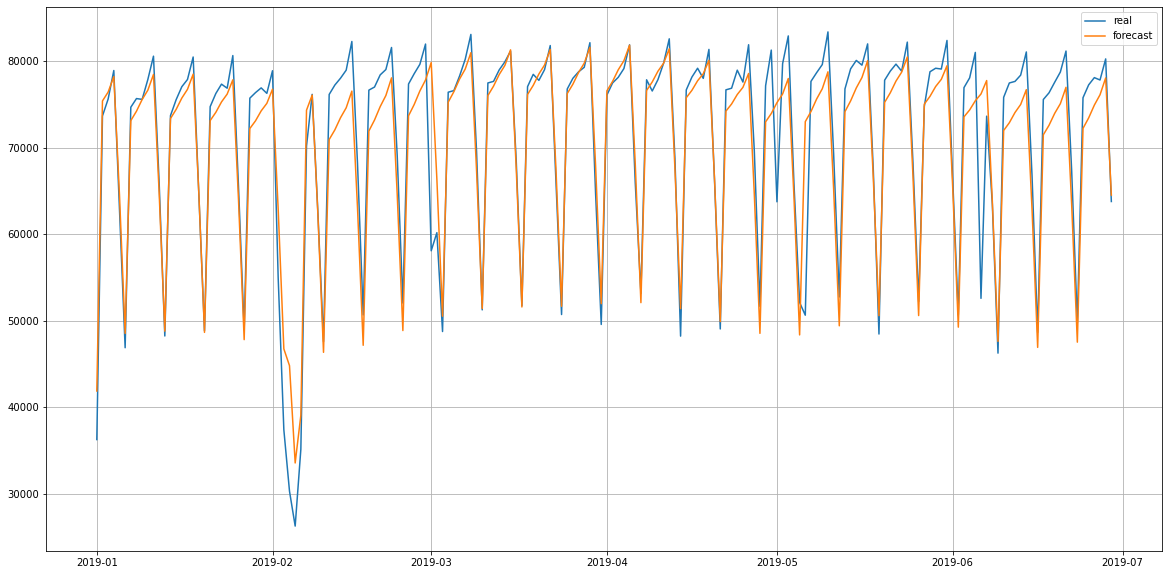

In [37]:
plt.figure(figsize=(20,10))
plt.plot(df_A2['ds'][-365:-185], df_A2['y'][-365:-185], label='real') # 실제: 파란선
plt.plot(forecast['ds'][-365:-185], forecast['yhat'][-365:-185], label='forecast') # 예측: 주황선
plt.grid()
plt.legend()
plt.show()

## 2019년 하반기 예측 비교

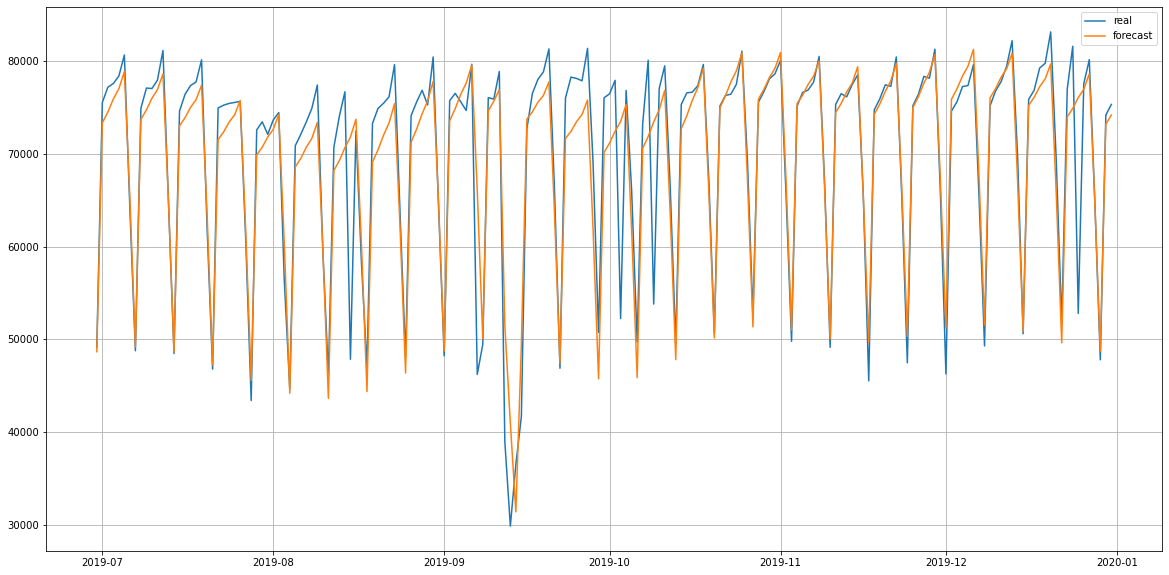

In [38]:
plt.figure(figsize=(20,10))
plt.plot(df_A2['ds'][-185:], df_A2['y'][-185:], label='real')
plt.plot(forecast['ds'][-185:], forecast['yhat'][-185:], label='forecast')
plt.grid()
plt.legend()
plt.show()